#### План:  
1. Приоритизировать гипотезы;  
2. Произвести анализ A/B-теста:  
  2.1 Проверить статестически значимые различия по выручке и среднему чеку;   
  2.2 Исследовать выбросы и проверить результаты теста без них;   
  2.3 Сформировать вывод о продлении или прекращении теста.

#### Часть 1. Приоритизация гипотез.

In [6]:
#запустим библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import scipy.stats as stats
from math import factorial
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
#напечатаем первый датасет и покажем полное описание гипотез
df_h = pd.read_csv('/content/hypothesis.csv')
pd.set_option('max_colwidth',-1)

In [8]:
df_h['ICE'] = df_h['Impact'] * df_h['Confidence'] / df_h['Efforts']
df_h.round(1).sort_values(by='ICE',ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


In [9]:
df_h['RICE'] = df_h['Impact'] * df_h['Confidence'] * df_h['Reach'] / df_h['Efforts']
df_h.round(1).sort_values(by='RICE',ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


##### Выводы:
По методологии ICE необходимо браться за выполнение гипотез № 8,0 и 7, а согласно RICE - № 7,2,0 и 6, причем гопотеза номер 7 набрала в 2 раза выше оценку.  
Такая разница обусловлена тем, гипотеза номер 7 затронет всех пользователей сайта, а вот восьмая очень узкую категорию. Введу чего рекомендую следовать методологии RICE.

#### Часть 2. Анализ A/B-теста

In [12]:
df_o = pd.read_csv('/content/orders.csv')

In [13]:
#изучим типы данных
df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [14]:
#поменяем формат столбца с датой
df_o['date'] = pd.to_datetime(df_o['date'])

In [15]:
#убедимся что нет нулевой выручки
df_o.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [16]:
#проверим что есть только 2 группы теста
df_o['group'].unique()

array(['B', 'A'], dtype=object)

In [17]:
#найдем пользователей, которые попали в 2 разных группы 
df_o2 = df_o.pivot_table(index=['visitorId'],values = 'group',aggfunc = {'group':'nunique'}).reset_index()
df_o2.columns = ['visitorId','group2']
df_o2

,visitorId,group2
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


In [18]:
#посчитаем их кол-во
df_o2B= df_o2.query('group2 == 2')
df_o2B.count()

visitorId    58
group2       58
dtype: int64

##### Вывод:  
58 пользователей попали и в группу А и в группу B при проведении теста. Данные по ним нельзя считать корректными. Однако мы не можем убрать этих пользователей из следующего датасета с визитами, потому оставим их и в текущей таблице.

In [21]:
df_v = pd.read_csv('/content/visitors.csv')

In [22]:
#удостоверимся, что здесь также толькj 2 группы
df_v['group'].unique()

array(['A', 'B'], dtype=object)

In [23]:
#изучим второй датасет
df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [24]:
#поменяем формат столбца
df_v['date'] = pd.to_datetime(df_v['date'])

 #### Построим график кумулятивной выручки по группам

In [25]:
#оставим только 2 столбца и уберем дубликаты
datesGroups = df_o[['date','group']].drop_duplicates()

In [26]:
#сформируем датасет с кумулятивной выручкой
revenueAggregated = datesGroups.apply(lambda x: df_o[np.logical_and(df_o['date'] <= x['date'], df_o['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
revenueAggregated.columns = ['date','group','orders','visitor','revenue']

In [27]:
#visitorsAggregated = datesGroups.apply(lambda x: df_v[np.logical_and(df_v['date'] <= x['date'], df_v['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [28]:
#разделим прошлый датасет на 2 по группам
cumulativeRevenueA = revenueAggregated[revenueAggregated['group']=='A'][['date','revenue','orders']]
cumulativeRevenueB = revenueAggregated[revenueAggregated['group']=='B'][['date','revenue','orders']]

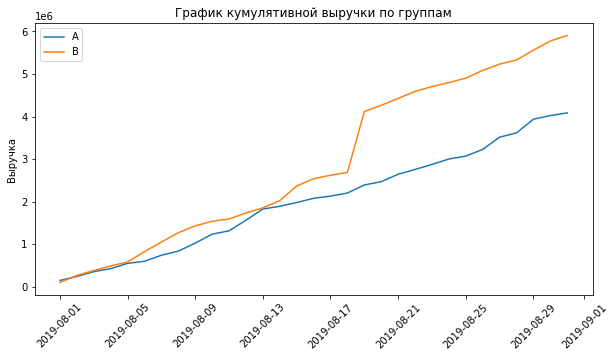

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

##### Вывод:  
Накопительная выручка в группе B стабильно больше, чем в группе А, начиная с 5.08.2019 года, также наблюдается резкий скачек выручку 17.08.2019 в группе B введу скорее всего крупной покупки одним пользователем.  


 #### Построим график кумулятивного среднего чека по группам.

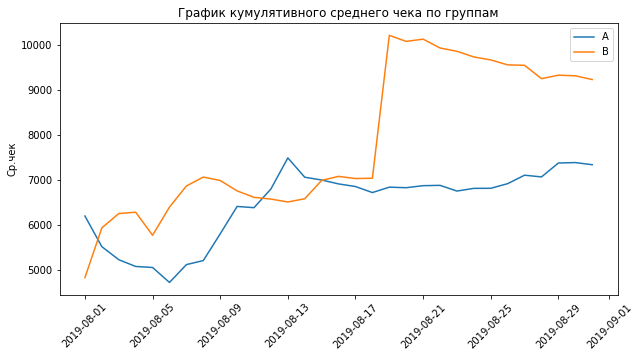

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Ср.чек")
plt.legend()
plt.show()

##### Вывод:
Накопительный средний чек ведет себя нестабильно в течение проводимого тестирования, 8.07.2019 наблюдается резкий скачек среднего чека и далее с каждым днем он уменьшается, что говорит о том, что больше таких крупных покупок не было.

 #### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

In [31]:
#объеденим 2 датасета
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

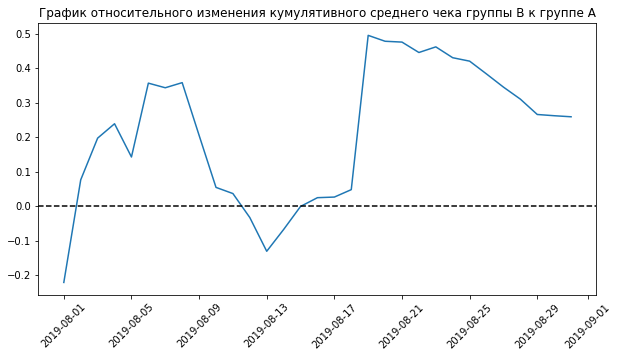

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

##### Вывод:  
Отношение накопительного среднего чека нестабильно - в данных имеются крупные заказы, т.е. выбросы.

 #### Построим график кумулятивной конверсии по группам

In [33]:
#сформируем датасет с кумулятивным кол-вом заказов
visitorsAggregated = datesGroups.apply(lambda x: df_v[np.logical_and(df_v['date'] <= x['date'], df_v['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [34]:
#объеденим 2 датасета: с выручкой и кол-вом заказов с с кол-вом визитов
cumulativeData = revenueAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [35]:
#посчитаем конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [36]:
#разделим график на 2 группы 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

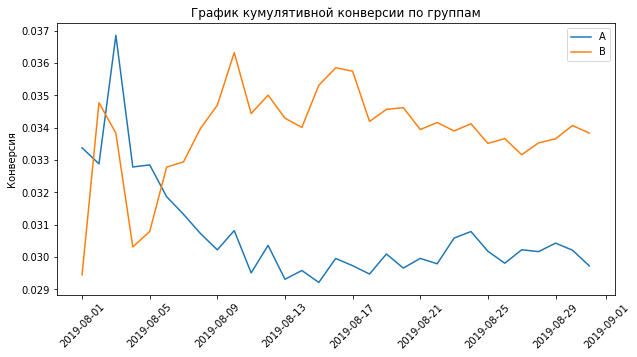

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Конверсия")
plt.legend()
plt.show()

##### Вывод:  
 Конверсия в покупателей в группе B значительно выше, начиная с 5.08.2019г, для обеих групп значения достаточно стабильны и колеблятся в тысячных долях.

#### Построим график относительного изменения кумулятивной конверсии группы B к группе A

In [38]:
#соедим 2 датасета только по нужным столбцам
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

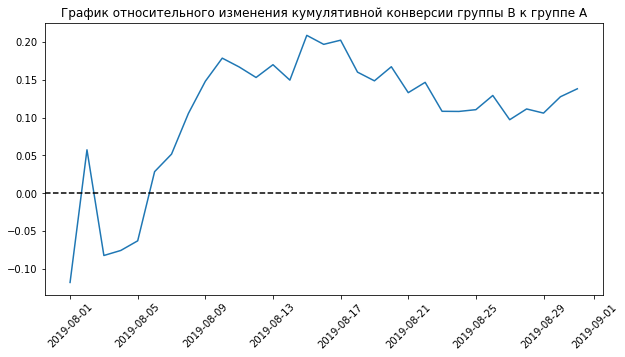

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.show()

##### Вывод:  
В начале теста группа B по кумулятивной конверсии группы B к группе A значительно отставала, однако после 5.08.2019 года  вырвалась вверх.


#### Построим точечный график количества заказов по пользователям

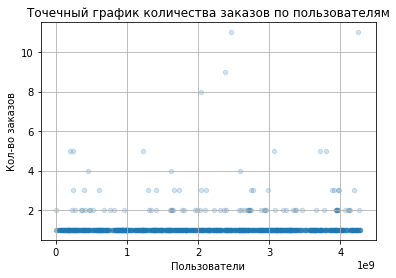

In [40]:
df_ov = df_o.pivot_table(index = 'visitorId',values = 'transactionId', aggfunc = 'count').reset_index()
df_ov.plot(x = 'visitorId', y = 'transactionId', kind = 'scatter',grid = True, alpha = 0.2)
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel("Кол-во заказов")
plt.xlabel("Пользователи")
plt.show()

##### Вывод:  
Большая часть пользователей совершило по 1 заказу, значимую долю имеют и те, кто совершил 2 заказа. Всех, кто совершил больше 2х заказов можно считать аномальными пользователями, однако стоит это проверить и другим способом.

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [41]:
np.percentile(df_ov['transactionId'], [95, 99])

array([2., 4.])

##### Вывод:  
5% пользователей совершили 2 и более заказ и 1% пользователей совершили 4 и более заказа. Введу чего и тех и других будем считать аномальными.

#### Построим точечный график стоимостей заказов

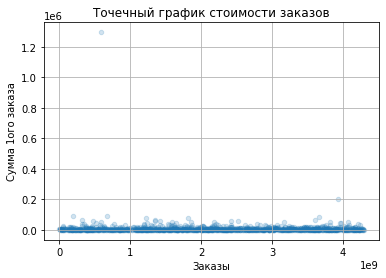

In [42]:
df_ot = df_o[['transactionId','revenue']]
df_ot.plot(x = 'transactionId', y = 'revenue', kind = 'scatter',grid = True, alpha = 0.2)
plt.title('Точечный график стоимости заказов')
plt.ylabel("Сумма 1ого заказа")
plt.xlabel("Заказы")
plt.show()

##### Вывод:  
Большая часть заказов имеет сумму до 200 000, однако существует и 1 заказ, который составил 1 200 000. 


#### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [43]:
np.percentile(df_ot['revenue'], [95, 99])

array([28000. , 58233.2])

##### Вывод:  
5% заказов имеют стоимость больше 28 000, а 1% - больше 58 233. Границей аномальных заказов по сумме считаем по 95ому проценталю. 


#### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [44]:
# Нулевая гипотеза - нет статестической значимости в конверсиях групп А и B 
# Альтернативная гипотеза - есть статестическая значимость в конверсиях групп А и B 

In [45]:
#сгруппируем датасет с визитами по группам и переназовем столбцы
visitorsADaily = df_v[df_v['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsBDaily = df_v[df_v['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [46]:
#сформируем датасеты с кумулятивным трафиком по группам
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [47]:
#переимнуем столбцы и уберем лишние
ordersACummulative = cumulativeDataA[['date','orders','revenue']]
ordersACummulative.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [48]:
ordersBCummulative = cumulativeDataB[['date','orders','revenue']]
ordersBCummulative.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [50]:
#объеденим все датасеты в один
data = (
    ordersACummulative.merge(
        ordersBCummulative, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [51]:
#посчитаем кол-во уникальных заказов на одного пользователя в каждой группе
ordersByUsersA = (
    df_o[df_o['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    df_o[df_o['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [52]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [53]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.008
0.138


##### Вывод:  
По «сырым» данным различия в конверсии групп A и B есть, так как по результатам теста Манна-Уйтни мы получили значение меньше, чем 0.05, то есть мы принимаем нулевую гипотезу.  
Конверсия в группе B на 13.8% выше, чем в группе А.

####  Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [54]:
# Нулевая гипотеза - нет статестической значимости в среднем чеке групп А и B 
# Альтернативная гипотеза - есть статестическая значимость в среднем чеке групп А и B 

In [55]:
print('{0:.3f}'.format(stats.mannwhitneyu(df_o[df_o['group']=='A']['revenue'], df_o[df_o['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(df_o[df_o['group']=='B']['revenue'].mean()/df_o[df_o['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


##### Вывод:  
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

#### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [56]:
# Нулевая гипотеза - нет статестической значимости в конверсиях групп А и B по 'очищенным данным'
# Альтернативная гипотеза - есть статестическая значимость в конверсиях групп А и B  по 'очищенным данным'

In [57]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = df_o[df_o['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape) 

(74,)


In [58]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [59]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
0.173


##### Вывод:  
Существует 74 пользователя с аномально высокой выручкой. Если их исключить из выборки, то по тесту Манна-Уитни значение p-values составит 0.007, что демонстирует нам, что мы  отвергаем нулевую гипотезу.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [60]:
# Нулевая гипотеза - нет статестической значимости в среднем чеке групп А и B по 'очищенным' данным 
# Альтернативная гипотеза - есть статестическая значимость в среднем чеке групп А и B  по 'очищенным' данным 

In [61]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            df_o[
                np.logical_and(
                    df_o['group'] == 'A',
                    np.logical_not(df_o['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            df_o[
                np.logical_and(
                    df_o['group'] == 'B',
                    np.logical_not(df_o['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        df_o[
            np.logical_and(
                df_o['group'] == 'B',
                np.logical_not(df_o['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / df_o[
            np.logical_and(
                df_o['group'] == 'A',
                np.logical_not(df_o['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.369
-0.020


##### Вывод:  
Cтатистическая значимость достигнута в разнице среднего чека  между группами по «очищенным» данным, p-values составляет 0.481. При этом средний чек меньше на 1.4% в группе B относительно А.

####  Решение по результатам теста

**Остановить тест, зафиксировать победу одной из групп**  
- существуют статестически значимые отличия по выручке в группах А и B, как по 'сырам' данным, так и выборке без выбросов;  
- разница в среднем чеке статетически не значима;
- график различия конверсии между группами демонстируем, что результаты группы B лучше группы A.